<h1> Functionality 3 - Shortest Ordered Route</h1>

In [99]:
#import libraries
import pandas as pd
import csv
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.shortest_paths.weighted import single_source_dijkstra
import collections
import heapq
from collections import defaultdict
from itertools import groupby
from ipywidgets import HTML
from ipyleaflet import Map, basemaps, basemap_to_tiles, Polyline, Marker, Icon, Popup
from IPython.display import Image

<h2> Read and clean the data </h2>

In [2]:
#create variables to store the path of data containing distance and time distance
path_distance = "USA-road-d.CAL.gr"
path_time_distance = "USA-road-t.CAL.gr"

In [3]:
#function to check the contents of the file containing distance by printing only few lines
def data_view(path):
    line_num = 0
    with open(path, encoding='utf-8') as file:
        for i in file:
            if (line_num < 10):
                print(i)
                line_num += 1

In [4]:
#call the function by passing the path containing file with "distance"
data_view(path_distance)

c 9th DIMACS Implementation Challenge: Shortest Paths

c http://www.dis.uniroma1.it/~challenge9

c TIGER/Line graph USA-road-d.CAL

c

p sp 1890815 4657742

c graph contains 1890815 nodes and 4657742 arcs

c

a 1 1048577 456

a 1048577 1 456

a 2 1048578 2389



In [5]:
#call the function by passing the path containing file with "time distance"
data_view(path_time_distance)

c 9th DIMACS Implementation Challenge: Shortest Paths

c http://www.dis.uniroma1.it/~challenge9

c TIGER/Line graph USA-road-t.CAL

c

p sp 1890815 4657742

c graph contains 1890815 nodes and 4657742 arcs

c

a 1 1048577 1139

a 1048577 1 1139

a 2 1048578 5972



In [6]:
#function to consider only the lines after 7th line, split the values and store the necessary data in lists
node1 = []
node2 = []
distance = []
def data_cleaning(path):
    line_num = 0
    with open(path, encoding='utf-8') as file:
        for i in file:
            if (line_num > 6):
                parts = i.split()
                node1.append(parts[1])
                node2.append(parts[2])
                distance.append(parts[3])
            line_num += 1

In [7]:
#call the function by passing the path containing file with "distance"
data_cleaning(path_distance)

In [8]:
#create a dataframe of the lists containing distance with another column (ie. network distance = 1) 
df = pd.DataFrame(
    {'source': node1,
     'target': node2,
     'distance': distance,
     'weight' : 1
    })

In [9]:
#check how the dataframe containing distance looks
df

,source,target,distance,weight
0,1,1048577,456,1
1,1048577,1,456,1
2,2,1048578,2389,1
3,1048578,2,2389,1
4,3,1048579,358,1
...,...,...,...,...
4657737,1890815,1048576,5642,1
4657738,989247,1048576,3212,1
4657739,1048576,989247,3212,1
4657740,1048572,1890810,7230,1


In [10]:
#call the function by passing the path containing file with "time distance"
data_cleaning(path_time_distance)

In [11]:
#create a dataframe of the lists containing time distance with another column (ie. network distance = 1) 
df_td = pd.DataFrame(
    {'source': node1,
     'target': node2,
     'time_distance': distance,
     'weight' : 1
    })

In [12]:
#check how the dataframe containing time distance looks
df_td

,source,target,time_distance,weight
0,1,1048577,456,1
1,1048577,1,456,1
2,2,1048578,2389,1
3,1048578,2,2389,1
4,3,1048579,358,1
...,...,...,...,...
9315479,1890815,1048576,14105,1
9315480,989247,1048576,8030,1
9315481,1048576,989247,8030,1
9315482,1048572,1890810,18076,1


<h2> The shortest route function </h2>

<h5> I am going to be using a brute force approach in which I will find the shortest distance between the source node to the first node in the list, then first node to second node, then second node to third node and so on, till the destination node and add up the distances </h5>

In [15]:
#create a class called Graph where 
#self.edges is a dict of all possible next nodes e.g. {'1': ['4', '3', '8', '9'], ...}
#self.weights has all the weights between two nodes, with the two nodes as a tuple as the key e.g. {('1', '2'): 1, ('5', '9'): 1, ...}

class Graph():
    def __init__(self):
        self.edges = defaultdict(list)
        self.weights = {}
    
    def add_edge(self, from_node, to_node, weight):
        # assuming edges are bi-directional
        self.edges[from_node].append(to_node)
        self.edges[to_node].append(from_node)
        self.weights[(from_node, to_node)] = weight
        self.weights[(to_node, from_node)] = weight

In [16]:
#call the Graph class
graph = Graph()

In [17]:
#take the input in which first node represents the source and the last node represents the destination
list_of_nodes_to_dest = []
def take_input():
    while True:
        inp = input()
        if inp == "":
            break
        else:
            list_of_nodes_to_dest.append(inp)
            
    #pack the graph, source input and destination input into a tuple ie. (graph,source,destination)
    res = [(graph ,list_of_nodes_to_dest[i], list_of_nodes_to_dest[i + 1])
           for i in range(len(list_of_nodes_to_dest) - 1)] 
    
    #choose which type of distance to consider
    print("Choose 1 for distance, 2 for network distance and 3 for time distance")
    inp = input()   
    return inp,res

In [18]:
inp,res = take_input()

21
22
23
24

Choose 1 for distance, 2 for network distance and 3 for time distance
2


In [19]:
#create an edge list with source, target and distance/network distance/time distance
edge_list = []
if inp == '1':
    for i,j in df.iterrows():
        edge_list.append((j[0],j[1],j[2]))
elif inp == '2':
    for i,j in df.iterrows():
        edge_list.append((j[0],j[1],j[3]))
elif inp == '3':
    for i,j in df_td.iterrows():
        edge_list.append((j[0],j[1],j[2]))

In [20]:
#check the length of edge list
len(edge_list)

4657742

In [21]:
#add the edge list to the graph
for edge in edge_list:
    graph.add_edge(*edge)

In [61]:
#shortest route function
def dijsktra(graph, initial, end):
    # shortest paths is a dict of nodes
    # whose value is a tuple of (previous node, weight)
    shortest_paths = {initial: (None, 0)}
    current_node = initial
    visited = set()
    
    while current_node != end:
        visited.add(current_node)
        destinations = graph.edges[current_node]
        weight_to_current_node = shortest_paths[current_node][1]

        for next_node in destinations:
            weight = graph.weights[(current_node, next_node)] + weight_to_current_node
            if next_node not in shortest_paths:
                shortest_paths[next_node] = (current_node, weight)
            else:
                current_shortest_weight = shortest_paths[next_node][1]
                if current_shortest_weight > weight:
                    shortest_paths[next_node] = (current_node, weight)
    
        next_destinations = {node: shortest_paths[node] for node in shortest_paths if node not in visited}
        if not next_destinations:
            return "Route Not Possible"
        # next node is the destination with the lowest weight
        current_node = min(next_destinations, key=lambda k: next_destinations[k][1])
        

    # Work back through destinations in shortest path
    path = []
    weights = []
    while current_node is not None:
        path.append(current_node)
        next_node = shortest_paths[current_node][0]
        weights.append(shortest_paths[current_node][1])
        current_node = next_node
    # Reverse path
    path = path[::-1]
    return weights[0],path

In [75]:
#call the shortest route function to find the shortest path and weight between each set of nodes
arr = []
for tripple in res:
    for i in dijsktra(*tripple):
        arr.append(i)
    print(tripple[1] +" -> " +tripple[2], dijsktra(*tripple))

21 -> 22 (12, ['21', '20', '19', '18', '1048591', '155', '139', '1048683', '124', '16', '17', '1048592', '22'])
22 -> 23 (11, ['22', '1048593', '2319', '1048641', '80', '66', '1048629', '65', '1048628', '1048625', '61', '23'])
23 -> 24 (1, ['23', '24'])


In [76]:
#store the resultant path and weight separately
res_path = [arr[i] for i in range(len(arr)) if i % 2 != 0] 
res_weight = [arr[i] for i in range(len(arr)) if i % 2 == 0] 

In [78]:
#flatten the list of lists of path
flattened_list = []
for x in res_path:
    for y in x:
        flattened_list.append(y)

In [79]:
#clean up the path and add up the weights of the set of nodes
res_path = [x[0] for x in groupby(flattened_list)]
res_weight  = sum(res_weight)

In [81]:
print("The shortest route from " + list_of_nodes_to_dest[0] +" to " + list_of_nodes_to_dest[-1] +" is:\n" +str(res_path))
print("The total weight is " +str(res_weight))

The shortest route from 21 to 24 is:
['21', '20', '19', '18', '1048591', '155', '139', '1048683', '124', '16', '17', '1048592', '22', '1048593', '2319', '1048641', '80', '66', '1048629', '65', '1048628', '1048625', '61', '23', '24']
The total weight is 24


<h2> Validate the result </h2>

In [82]:
#use networkx to create an edgelist (for validating the results)
G = nx.from_pandas_edgelist(df,'source','target', edge_attr='weight')

In [83]:
#run the below function to find the shortest path for a set of nodes(for validating the results)
single_source_dijkstra(G,'21','22')

(12,
 ['21',
  '20',
  '19',
  '18',
  '1048591',
  '155',
  '139',
  '1048683',
  '124',
  '16',
  '17',
  '1048592',
  '22'])

<h2> Visualization of the graph </h2>

In [84]:
#read the node informtion data
df_data = pd.read_csv('node_information_file.csv')

In [85]:
#convert the latitudes and logitudes in proper format by dividing them by 1000000
#store the latitude and logitude of the source, must-pass and destination nodes in a list
location_latlongs = []
for x in list_of_nodes_to_dest:
    location_latlong = []
    location_latlong.append(float(df_data["Longitude"].iloc[int(x)-1])/1000000)
    location_latlong.append(float(df_data["Latitude"].iloc[int(x)-1])/1000000)
    location_latlong.append(x)
    location_latlongs.append(location_latlong)

In [87]:
#store the latitude and longitude of all the nodes in the shortest route from sourse to destination
path_latlongs = []
for x in res_path:
    path_latlong = []
    path_latlong.append(float(df_data["Longitude"].iloc[int(x)-1])/1000000)
    path_latlong.append(float(df_data["Latitude"].iloc[int(x)-1])/1000000)
    path_latlongs.append(path_latlong)

In [94]:
#create a visulaization for graph
def visualize():
    center = location_latlongs[1]

    m = Map(center=center, zoom=8)

    icon1 = Icon(icon_url='https://img.icons8.com/ultraviolet/40/000000/map-pin.png', icon_size=[40, 40], icon_anchor=[20,40])
    icon2 = Icon(icon_url='https://img.icons8.com/officel/40/000000/map-pin.png', icon_size=[40, 40], icon_anchor=[20,40])
    icon3 = Icon(icon_url='http://icons.iconarchive.com/icons/custom-icon-design/flatastic-6/256/Circle-icon.png', icon_size=[10, 10], icon_anchor=[5,5], shadow_size=[5,5])

    line = Polyline(
        locations = [[
        path_latlongs,]],
        color = "#669df6" ,
        fill= False,
        weight = 2,
        stroke = True
    )

    m.add_layer(line)

    style = {'text-align': 'left','description_width': '150px'}
    i = 0
    while i < len(location_latlongs):
        if i == 0:
            message = HTML()
            message.placeholder = "Source"
            message.description = "Source"+"<br>Node ID: "+location_latlongs[i][2]+"<br>Lat:   "+ str(location_latlongs[i][1])+ "<br>Long:  "+ str(location_latlongs[i][0])
            message.style = style
            marker = Marker(location=location_latlongs[i], 
                            draggable=False, title="Source", 
                            icon=icon1, 
                            rise_on_hover=True, 
                            z_index_offset = 100)
            m.add_layer(marker);  
            marker.popup = message
        
        elif (len(location_latlongs)-i) == 1:
            message = HTML()
            message.placeholder = "Destination"
            message.description = "Destination"+"<br>Node ID: "+location_latlongs[i][2]+"<br>Lat:   "+ str(location_latlongs[i][1])+ "<br>Long:  "+ str(location_latlongs[i][0])
            message.style = style
            marker = Marker(location=location_latlongs[i], 
                            draggable=False, 
                            title="Destination", 
                            icon=icon2, 
                            rise_on_hover=True)
            m.add_layer(marker);
            marker.popup = message
        
        else:
            message = HTML()
            message.placeholder = "Waypoint"
            message.description = "Waypoint: "+str(i)+""+"<br>Node ID: "+location_latlongs[i][2]+"<br>Lat:   "+ str(location_latlongs[i][1])+ "<br>Long:  "+ str(location_latlongs[i][0])
            message.style = style
            marker = Marker(location=location_latlongs[i], 
                            draggable=False, 
                            icon=icon3, 
                            title="Waypoint", 
                            rise_on_hover=True)
            m.add_layer(marker);
            marker.popup = message
        i += 1

    return(m)

In [95]:
#call the visulaization function
m = visualize()

In [96]:
#print the map of visulalization
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

<h5> I am attaching the png images of the route as the map visualization is dynamic and it will not show up on github. </h5>

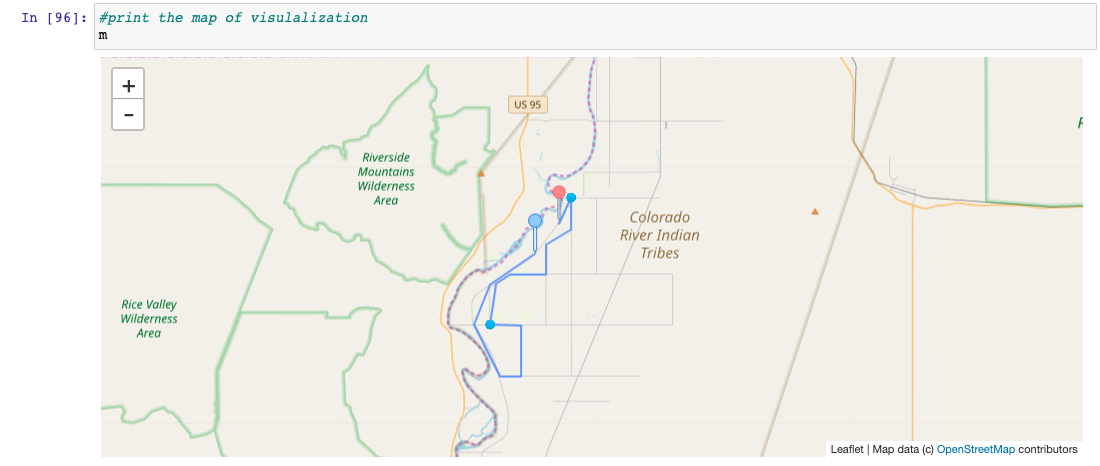

In [104]:
Image(filename = 'nodes_route.png') 

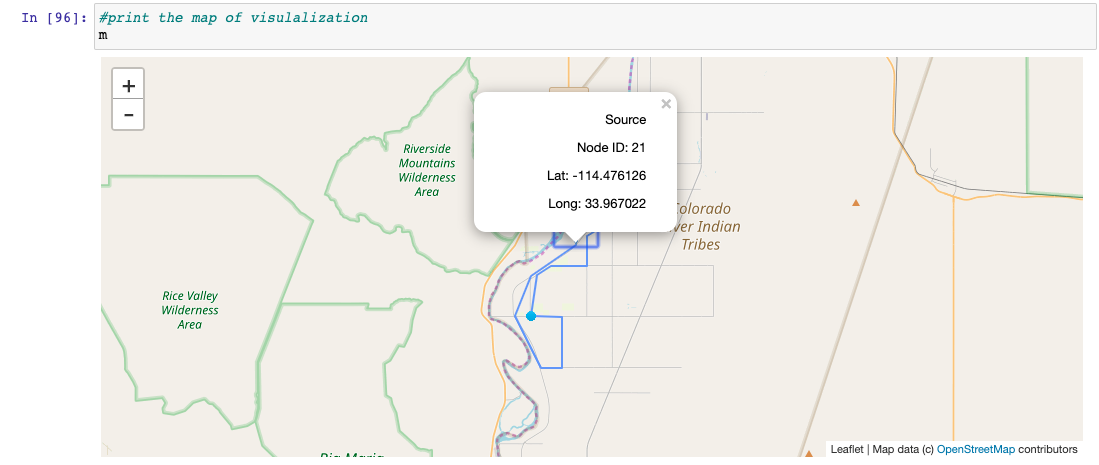

In [100]:
Image(filename = 'source_node.png') 

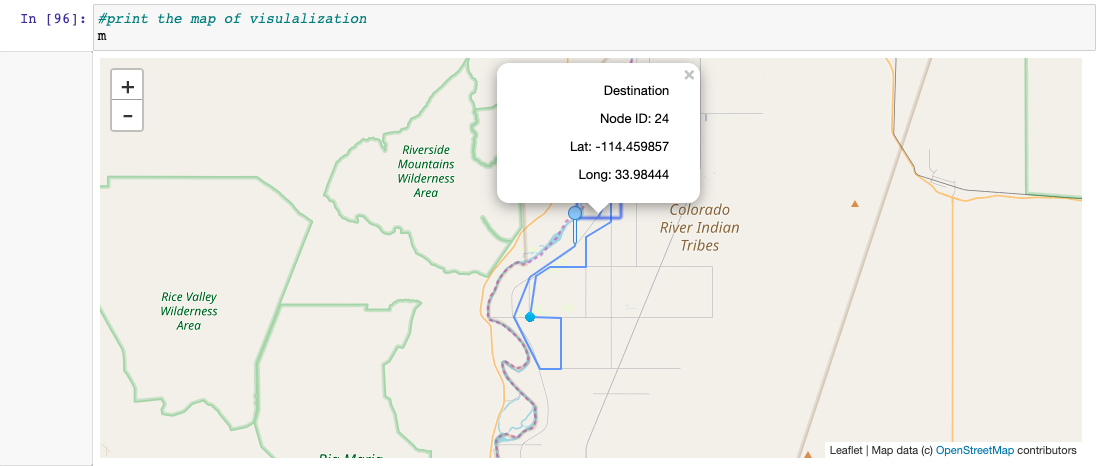

In [101]:
Image(filename = 'destination_node.png') 

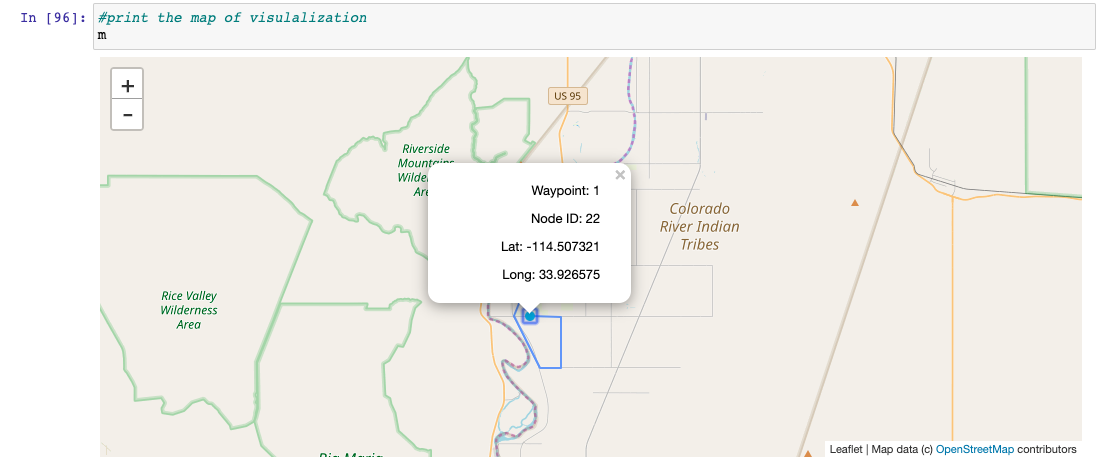

In [102]:
Image(filename = 'waypoint_node_1.png') 

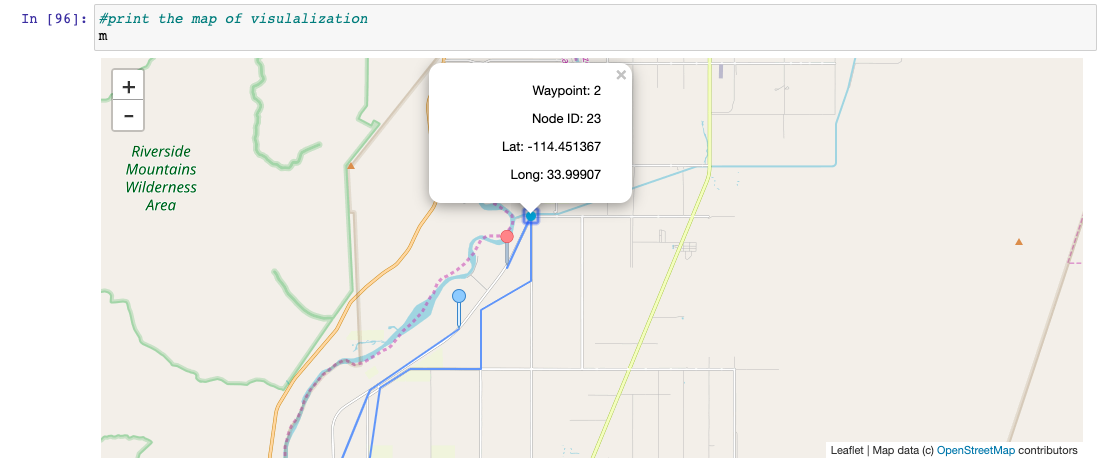

In [103]:
Image(filename = 'waypoint_node_2.png') 